# Dynamic analysis of 2D-beam

In this notebook we have a cantilever beam which is clamped at the left-hand side and a force is applied on the right hand side.

The analysis is based on linear elasticity and a Newmark time-integration to plot the displacement over time.

This is an example of a dynamic structure and is a benchmark to modal analysis.

In [1]:
from dolfin import *
import mshr
import numpy as np
import matplotlib.pyplot as plt

# Form compiler options
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["optimize"] = True
%matplotlib inline

The example is a domain with length of 1 meter and a width of 2.5 centimeters. We take material properties of steel and do not take damping into account by setting it to zero.

The force applied is a lineaic pressure of 100 kPa per meter at the end of the beam. This gives 2,5 kN force per meter if we take the height of 2,5 cm into account.

Gravity is taken into account but it can be neglected under the current material properties and applied load. However, for future applications of modal analysis it is easy to have a body force included as well.

The force and inertia are per meter as the width of the beam is not defined in 2D (force, density).

In [2]:
# Domain parameters
ll = 1.0
ww = 0.025

# Mesh density
dens = 30

# Elasticity parameters
E, nu = 2.1e9, 0.3
mu, lmbda = Constant(E/(2*(1 + nu))), Constant(E*nu/((1 + nu)*(1 - 2*nu)))

# Mass density and viscous damping coefficient
rho, eta = 7.8e4, 0.0

# applied force
pressure = -5e4
grav = -9.81

Creating a mesh and function space with the relevant functions:

There are a number of functions defined on the vectorspace $\mathcal{V}$: the displacement, velocity and acceleration. 



In [3]:
# Create mesh
P0 = Point(0., 0.)
P1 = Point(ll, ww)
domain = mshr.Rectangle(P0, P1)
mesh = mshr.generate_mesh(domain, dens)

# Create function space
V = VectorFunctionSpace(mesh, "Lagrange", 1)

# Create test and trial functions, and source term
u1, w = TrialFunction(V), TestFunction(V)

# Fields from previous step
u0, v0, a0 = Function(V), Function(V), Function(V)

Time stepping parameters are set so that we look at the first natural period with a small time step. These settings have to be set here to determine the first step of the velocity and acceleration.

In [4]:
period0 = 0.71337826
# Time stepping parameters
beta, gamma = 0.25, 0.5
dt = 0.005*period0
t, T = 0.0, period0*2

Calculating velocity and acceleration at the first time step using $u0$, $v0$ and $a0$ defined in the previous block effectively setting initial position and velocity to zero

In [5]:
# Velocity and acceleration at first time step
v1 = (gamma/(beta*dt))*(u1 - u0) - (gamma/beta - 1.0)*v0 - dt*(gamma/(2.0*beta) - 1.0) * a0
a1 = (1.0/(beta*dt**2))*(u1 - u0 - dt*v0) - (1.0/(2.0*beta) - 1.0)*a0

Marking the boundaries an applying boundary conditions. The beam is clamped on the left, therefore Dirichlet boundary conditions are applied to set the displacement to zero there.

In [6]:
# Mark boundary subdomians
class BoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (near(x[0], 0.))
    
class BoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (near(x[0], ll))
    
class BoundaryTop(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (near(ww, x[1]))
    
class BoundaryBottom(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (near(0, x[1]))

# set boundary markers
boundary_markers = FacetFunction('size_t', mesh)
left = BoundaryLeft()
right = BoundaryRight()
top = BoundaryTop()
bottom = BoundaryBottom()
left.mark(boundary_markers, 0)
top.mark(boundary_markers, 1)
right.mark(boundary_markers, 2)
bottom.mark(boundary_markers, 3)

# Define measure ds to apply markers
ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)

Defining loads and taking inertia into account for the governing balance equation

The material is modeled as homogenous and isotropic so the stress tensor is given simply by:
$$
\boldsymbol{\sigma} = \mu\boldsymbol{\epsilon} + \lambda \text{tr}(\boldsymbol{\epsilon})\mathbf{I}
$$

In [7]:
# Define loads
b = Constant((0.0, grav))
tt = Constant((0.0, pressure))

# Define boundary conditions
bc = DirichletBC(V, Constant((0.0, 0.0)), left)

# Stress function
def sigma(u, v):
    return 2.0*mu*sym(grad(u)) + (lmbda*tr(grad(u)) + eta*tr(grad(v)))*Identity(len(u))

# Governing balance equation
F = (rho*dot(a1, w) + inner(sigma(u1, v1), sym(grad(w))))*dx - dot(b, w)*dx - dot(tt, w)*ds(2)

# Extract bilinear and linear forms from F
a, L = lhs(F), rhs(F)

u = Function(V)
A, b = assemble_system(a, L, bc)

Writing a Newmark-integration scheme to update the problem based on average constant acceleration:

In [8]:
# Define update
def update(u, u0, v0, a0, beta, gamma, dt):
    # get vectors (reference)
    u_vec, u0_vec = u.vector(), u0.vector()
    v0_vec, a0_vec = v0.vector(), a0.vector()
    
    # update acceleration and velocity
    a_vec = (1.0 / (2.0*beta))*((u_vec - u0_vec - v0_vec*dt)/(0.5*dt*dt) - (1.0 -2.0*beta)*a0_vec)
    # v = dt * ((1-gamma)*a0 + gamma*a) +v0
    v_vec = dt*((1.0-gamma)*a0_vec + gamma*a_vec) + v0_vec
    
    # Update (t(n) <-- t(n+1))
    v0.vector()[:], a0.vector()[:] = v_vec, a_vec
    u0.vector()[:] = u.vector()

Integrating the problem over time and applying the load at each time step:

In [9]:
file = File("beam_direct/displacement.pvd")
file << (u, float(t))
while t <= T:
    t+=dt
    b = assemble(L)
    bc.apply(b)
    solve(A, u.vector(), b)
    update(u, u0, v0, a0, beta, gamma, dt)
    file << (u, float(t))

Plot the displacement at the last time step:

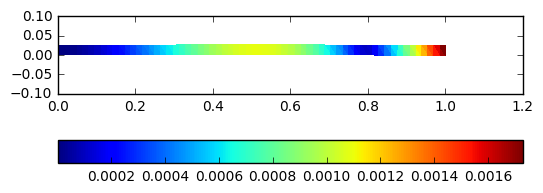

In [10]:
plt.figure()
ax = plot(u, mode="displacement")
cbar = plt.colorbar(ax, orientation='horizontal')
plt.ylim([-0.1, 0.1])
plt.show()

In [11]:
t

1.4303234112999959